In [ ]:
#JJ McCauley + LOGAN KELSCH 

#IMPORT LIBRARIES-------------------------------------------------------

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from keras.optimizers import SGD
from keras.initializers import GlorotUniform
from keras.initializers import RandomNormal
from keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE
from funcs_data_preprocess import *

#hahaha dont turn this on with high epoch or else
#tf.config.experimental.set_memory_growth

#LOAD DATA FROM CSV-------------------------------------------------------

# Load the dataset
data_csv_ripped = pd.read_csv('catted_1-8.csv')

print(f"TEMP CUTOUT:\n\tTOTAL FEATURES CUT -\n\t\t{len(data_csv_ripped.iloc[int(len(data_csv_ripped)*.9):])}")

data = data_csv_ripped.iloc[:int(len(data_csv_ripped)*.9)]

testFor = 'r10'
timeSteps = 5
tType = testFor[0]
#testing random feature drops
#TREND

data = data.drop(columns=['FT','FT.1'])
#data = data.drop(columns=['FT'])
#--------------------------------------
#targets-------------------------------
#r----  1   2   3   5   10  15  30  60
data = target_setter(data, testFor)
#data['Dr3_Model'] = 0
#confirming X and Y features post training
Xfeatures = data.columns[:-1]
Yfeatures = data.columns[-1]
print("TESTED FEATURES: ")
print(Xfeatures)
print("TESTING FOR: ")
print(Yfeatures)
#PROCESS THE DATA-------------------------------------------------------

# Separate features and target
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

test_size       = 0.5
num_isol_feats  = 3
comps_PCA       = 10

#normalized values
t0930           = -0.32007092
t1045           = -0.141503587
t1200           = 0.03706375

X = normalize_from_tt_split(X, X, test_size)
#X = reform_with_PCA_isolated(X, X, test_size, num_isol_feats, comps_PCA)
X = reformat_to_lstm(X, timeSteps)

y = y[timeSteps:]
y = np.array(y)

print('\nX shape == {}.'.format(X.shape))
print('y shape == {}.\n'.format(y.shape))



print(f'Raw Sample Count:\t{len(X)}')
X, y = remove_zero_mo_samples(X, y, timeSteps)
X, y = remove_extra_filter(X, y, timeSteps, t0930, t1045)
print(f'Remaining Sample Count:\t{len(X)}')

X = X[:,:,:-1]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)

#to remove overlapping values that were left from training set
X_test = X_test[timeSteps:]
y_test = y_test[timeSteps:]

print('\nX_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))
print('X_test shape == {}.'.format(X_test.shape))
print('y_test shape == {}.\n'.format(y_test.shape))


#LEARNING RATES____________________________________________________________________________________________
from keras.optimizers.schedules import ExponentialDecay
lr_schedule = ExponentialDecay(
    #good rough val to start, .25, good val to end at .0015.
    #5k epoch should be: .25, 8565, .9995, true
    0.01,
    decay_steps=100,
    decay_rate=0.997,
    staircase=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='loss',
    factor=0.95, 
    patience=5, 
    min_lr=1e-6
)

#LOSS FUNCTION
from keras.saving import get_custom_objects
from keras.saving import register_keras_serializable
get_custom_objects().clear()
#CUSTOM LOSS 1_______________________________________________________________________________________________
from keras.src import ops
from keras.src.losses.loss import squeeze_or_expand_to_same_rank
@register_keras_serializable(name="skew_loss")
def skew_loss(y_true,y_pred,sFact=4):
    fact = 20
    y_pred = ops.convert_to_tensor(y_pred)
    y_true = ops.convert_to_tensor(y_true, dtype=y_pred.dtype)
    #y_true, y_pred = squeeze_or_expand_to_same_rank(y_true, y_pred)
    error = ops.subtract(y_pred, y_true)
    a = ops.convert_to_tensor(ops.cast(abs(y_pred-y_true)*fact <= 1,tf.float32), dtype=tf.float32)
    b = ops.convert_to_tensor(ops.cast(y_pred < 0,tf.float32), dtype=tf.float32)
    h = ops.convert_to_tensor(2, dtype=error.dtype)
    return ops.mean(
        ops.where(
            a==1,
            0,
            ops.square(error)-(1/fact)
        ))

opt1 = SGD(learning_rate=0.01)
opt2  = tf.keras.optimizers.Adam(learning_rate=0.001)
opt3 = SGD(learning_rate=lr_schedule)
opt4 = SGD(learning_rate=0.02, momentum=0.9)
opt5 = tf.keras.optimizers.Adam(learning_rate=0.01)

#BUILD AND LOAD MODEL__________________________________________________________________________________________


#print(X_train.shape[0]/time_steps)
#X_train = np.reshape(X_train,((X_train.shape[0]//time_steps), time_steps, 35))  # Reshape to (batch_size, 5 time steps, 35 features)
#y_train = y.reshape(1,-1)
from tensorflow.keras import regularizers

def build_LSTM_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(X_train.shape[1],X_train.shape[2])),
        tf.keras.layers.LSTM(512, activation='tanh', recurrent_dropout=0.0, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.Dropout(0.2),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LSTM(256, activation='tanh', recurrent_dropout=0.1, return_sequences=False, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        #tf.keras.layers.Dropout(0.2),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(128),# kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(64),# kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        #tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='linear')
    ])
    model.compile(optimizer=opt4,
                  loss='mse'
                  ,metrics=['R2Score','root_mean_squared_error'])
    return model

def load_model():
    #loaded_model = tf.keras.models.load_model('tupleTrain.keras', custom_objects={'custom_loss':custom_loss})
    loaded_model = tf.keras.models.load_model('r30_10s_LSTM_8.keras')
    loaded_model.compile(optimizer=opt4,
                         loss='mse'
                         , metrics=['R2Score','root_mean_squared_error'])
    return loaded_model

#TRAIN THE MODEL WITH CUSTOMIZABLE EPOCHS-------------------------------------------------------

epochs = 100

early_stopping = EarlyStopping(monitor='loss', patience=20, mode='min', restore_best_weights=True)

cmp = 'C'
if tf.config.list_physical_devices('GPU'):
    cmp = 'G'
    pass
with tf.device('/'+cmp+'PU:0'):
    print('Running on: '+cmp+'PU\n')
    model = build_LSTM_model()
    #loaded_model = load_model()
    used_model = model
    history = used_model.fit(X_train, y_train, epochs=epochs,\
                        shuffle=True, verbose=1, validation_data=(X_test, y_test),\
                        batch_size=240,callbacks=[reduce_lr, early_stopping])

#EVALUATE THE MODEL AND VISUALIZE RESULTS-------------------------------------------------------

#show_all_results(used_model, history, X_test, y_test)

# LOSS
epochs = range(1, len(history.history['loss']) + 1)
plt.figure(figsize=(12, 6))
plt.plot(epochs[1:], history.history['loss'][1:], 'y', label='Training Loss')
plt.plot(epochs[1:], history.history['val_loss'][1:], 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
# ACCURACY

plt.plot(epochs[1:], history.history['R2Score'][1:], 'y', label='Training R2')
plt.plot(epochs[1:], history.history['val_R2Score'][1:], 'r', label='Validation R2')
plt.title('Training and Validation R2Score')
plt.xlabel('Epoch')
plt.ylabel('R2Score')
plt.ylim(bottom=-1)
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


#predicting the test set results
y_pred = used_model.predict(X_test) 


plt.scatter(y_pred, y_test, s=1)
plt.axis('tight')
plt.title('Testing Outputs')
plt.xlabel('y_pred')
plt.xlim(-.25,.25)
plt.ylim(-.25,.25)
plt.ylabel('y_test')
ax = plt.gca()
x_vals = np.array(ax.get_xlim())
y_vals = x_vals  # Since y = x
plt.plot(x_vals, y_vals, '-', color='black', label='y = x', linewidth=0.5)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0,color='black',linewidth=0.5)
plt.show()

#SCATTERPLOT #SCATTERPLOT  #SCATTERPLOT  #SCATTERPLOT  #SCATTERPLOT  #SCATTERPLOT  #SCATTERPLOT  #SCATTERPLOT  
plt.scatter(y_pred, y_test, s=1)
plt.grid()
plt.axis('tight')
plt.title('Testing Outputs')
plt.xlabel('y_pred')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.ylabel('y_test')
ax = plt.gca()
x_vals = np.array(ax.get_xlim())
y_vals = x_vals  # Since y = x
plt.plot(x_vals, y_vals, '-', color='black', label='y = x', linewidth=0.5)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0,color='black',linewidth=0.5)
plt.show()

used_model.save('r30_PCA10_tmp_out_change_name_asap.keras')

In [7]:
used_model.save('r30_PCA10_6.keras')

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error

def walk_forward_validation(X, y, model, n_splits=20, test_size=0.2):
    """
    Perform walk-forward validation for an LSTM model.

    Parameters:
    X (np.ndarray): 3D array of features with shape (n_samples, time_steps, n_features)
    y (np.ndarray): 1D array of labels with shape (n_samples,)
    model (tf.keras.Model): Compiled LSTM model
    n_splits (int): Number of walk-forward splits
    test_size (float): Proportion of the data to use as the test set in each split

    Returns:
    list: MSE scores for each split
    """
    n_samples = X.shape[0]
    test_set_size = int(test_size * n_samples)
    
    mse_scores = []

    # Split the data into n_splits segments
    for i in range(n_splits):
        # Define the index range for the training set (everything before the test set)
        train_end = int((i + 1) * (n_samples - test_set_size) / n_splits)

        # Define the test set
        X_train, X_test = X[:train_end], X[train_end:train_end + test_set_size]
        y_train, y_test = y[:train_end], y[train_end:train_end + test_set_size]

        # Ensure that your model is recompiled and retrained in each fold
        model_copy = tf.keras.models.load_model(model)
        model_copy.compile(optimizer='adam', loss='mse')  # Assuming MSE for regression

        # Fit the model on the current training set
        model_copy.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

        # Make predictions on the test set
        y_pred = model_copy.predict(X_test)

        # Calculate the mean squared error for this fold
        mse = mean_squared_error(y_test, y_pred)
        mse_scores.append(mse)

        print(f'Fold {i+1}/{n_splits}, MSE: {mse}')

    return mse_scores

# Example usage:
# Assuming you have already defined `X`, `y`, and compiled your LSTM model
# mse_scores = walk_forward_validation(X, y, lstm_model, n_splits=5, test_size=0.2)
X_vals = X_test
y_vals = y_test
print('X shape:',X_vals.shape,'\ny shape:',y_vals.shape)
scores = walk_forward_validation(X_test, y_test, 'LSTM_testtest.keras')
avgScore = 0
for score in scores:
    avgScore+=score
avgScore/=len(scores)

print('Average MSE:',avgScore)

In [ ]:
data.corr()

In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
new_model = tf.keras.models.load_model("r30_PCA10_1.keras")

y_pred = new_model.predict(X_test) 


plt.scatter(y_pred, y_test, s=1)
plt.axis('tight')
plt.title('Testing Outputs')
plt.xlabel('y_pred')
plt.xlim(-.25,.25)
plt.ylim(-.25,.25)
plt.ylabel('y_test')
ax = plt.gca()
x_vals = np.array(ax.get_xlim())
y_vals = x_vals  # Since y = x
plt.plot(x_vals, y_vals, '-', color='black', label='y = x', linewidth=0.5)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0,color='black',linewidth=0.5)
plt.show()

#SCATTERPLOT #SCATTERPLOT  #SCATTERPLOT  #SCATTERPLOT  #SCATTERPLOT  #SCATTERPLOT  #SCATTERPLOT  #SCATTERPLOT  
plt.scatter(y_pred, y_test, s=1)
plt.grid()
plt.axis('tight')
plt.title('Testing Outputs')
plt.xlabel('y_pred')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.ylabel('y_test')
ax = plt.gca()
x_vals = np.array(ax.get_xlim())
y_vals = x_vals  # Since y = x
plt.plot(x_vals, y_vals, '-', color='black', label='y = x', linewidth=0.5)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0,color='black',linewidth=0.5)
plt.show()

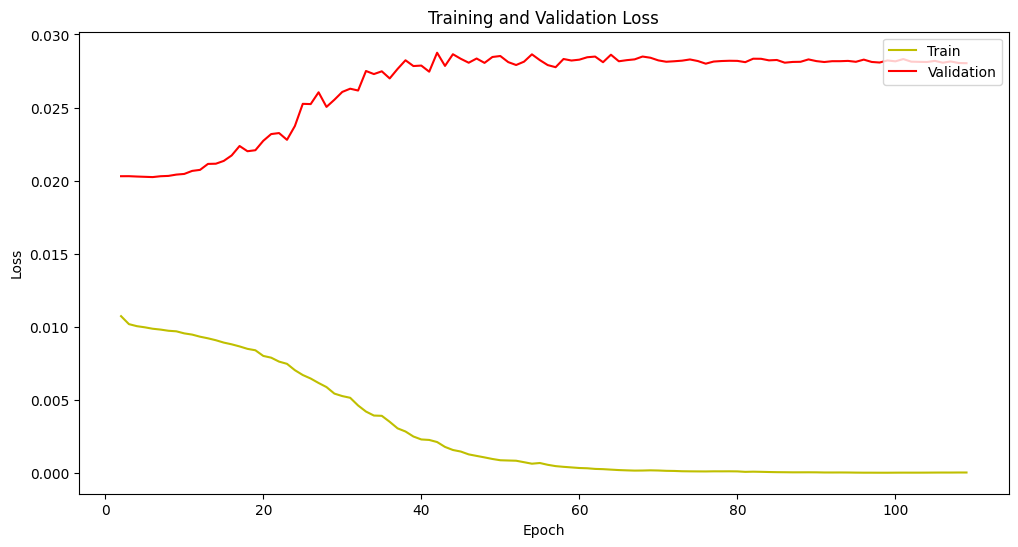

In [25]:
epochs = range(1, len(history.history['loss']) + 1)
plt.figure(figsize=(12, 6))
plt.plot(epochs[1:], history.history['loss'][1:], 'y', label='Training Loss')
plt.plot(epochs[1:], history.history['val_loss'][1:], 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()